##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-03-25 03:31:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 2404:6800:4003:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  59.3MB/s    in 1.4s    

2020-03-25 03:32:01 (59.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-03-25 03:43:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  29.3MB/s    in 4.9s    

2020-03-25 03:43:14 (29.3 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [0]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [0]:
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [0]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

['horse37-8.png', 'horse01-8.png', 'horse50-3.png', 'horse28-6.png', 'horse24-0.png', 'horse09-1.png', 'horse01-9.png', 'horse44-1.png', 'horse38-3.png', 'horse31-1.png']
['human09-26.png', 'human09-00.png', 'human06-04.png', 'human09-23.png', 'human10-29.png', 'human17-01.png', 'human03-09.png', 'human03-18.png', 'human11-01.png', 'human11-19.png']
total training horse images: 500
total training human images: 527


In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)


Epoch 1/20
Epoch 1/20
100/100 - 29s - loss: 0.5188 - acc: 0.7580 - val_loss: 0.5493 - val_acc: 0.8700
Epoch 2/20
Epoch 1/20
100/100 - 19s - loss: 0.4095 - acc: 0.8095 - val_loss: 0.3264 - val_acc: 0.9170
Epoch 3/20
Epoch 1/20
100/100 - 19s - loss: 0.3393 - acc: 0.8560 - val_loss: 0.2636 - val_acc: 0.9440
Epoch 4/20
Epoch 1/20
100/100 - 19s - loss: 0.3241 - acc: 0.8635 - val_loss: 0.4971 - val_acc: 0.9210
Epoch 5/20
Epoch 1/20
100/100 - 19s - loss: 0.3108 - acc: 0.8660 - val_loss: 0.2496 - val_acc: 0.9560
Epoch 6/20
Epoch 1/20
100/100 - 19s - loss: 0.2957 - acc: 0.8810 - val_loss: 0.5284 - val_acc: 0.9270
Epoch 7/20
Epoch 1/20
100/100 - 19s - loss: 0.3051 - acc: 0.8680 - val_loss: 0.3562 - val_acc: 0.9440
Epoch 8/20
Epoch 1/20
100/100 - 19s - loss: 0.3057 - acc: 0.8770 - val_loss: 0.5104 - val_acc: 0.9310
Epoch 9/20
Epoch 1/20
100/100 - 19s - loss: 0.2721 - acc: 0.8840 - val_loss: 0.4501 - val_acc: 0.9350
Epoch 10/20
Epoch 1/20
100/100 - 19s - loss: 0.2507 - acc: 0.8945 - val_loss: 0.33

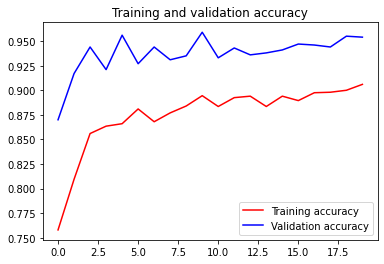

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

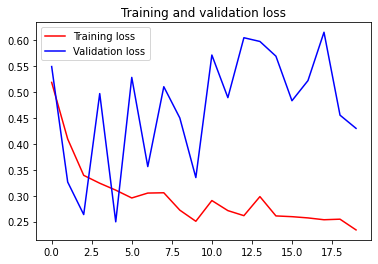

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()